In [1]:
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import torch
from torch.utils.data import random_split,DataLoader
from torch import nn
from PIL import Image
from torch.autograd import Variable

c:\ProgramData\Anaconda3\envs\Capstone_PT_GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#define the resolution that you want.
shape1=32
shape2=36

In [3]:
# scale the spec2D array. i.e. reduce the resolution.
def scale_array(x,new_size):
    min_el = np.min(x)
    max_el = np.max(x)
    y = np.array(Image.fromarray(x).resize(new_size))
    y = y/(max_el-min_el)+min_el
    y[y<np.average(y)/4]=0
    ymax = np.max(y)
    y[y==ymax]=max_el
    return y


In [4]:
winter_ds = xr.open_dataset('F:\\combined-small16x.nc',engine = "netcdf4",decode_times=False)
winter_ds

<xarray.Dataset>
Dimensions:    (time: 1001, freq: 64, dir: 72)
Coordinates:
  * time       (time) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * freq       (freq) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * dir        (dir) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Data variables:
    cott2D     (time, freq, dir) float32 ...
    cott2D05   (time, freq, dir) float32 ...
    rott2Dm1   (time, freq, dir) float32 ...
    rott2Dm15  (time, freq, dir) float32 ...
    cape2Dm25  (time, freq, dir) float32 ...
    cape2Dm3   (time, freq, dir) float32 ...
    cott2Dm05  (time, freq, dir) float32 ...
    cott2Dm1   (time, freq, dir) float32 ...

In [5]:
s = winter_ds["rott2Dm1"].values[6]
len(s[s<np.average(s)/4])

3508

In [6]:
def reduce_res(inp):
    l = len(inp)
    out = np.zeros((l,shape1,shape2))
    for i in range(0,l):
        out[i] = scale_array(inp[i],(shape2,shape1))
    return out

In [7]:
#use the original resolution of the spec2D.
rott2Dm1=winter_ds["rott2Dm1"].values
rott2Dm15 = winter_ds["rott2Dm15"].values
cape2Dm25 = winter_ds["cape2Dm25"].values
cape2Dm3 = winter_ds["cape2Dm3"].values
cott2Dm05 = winter_ds["cott2Dm05"].values
cott2Dm1 = winter_ds["cott2Dm1"].values
cott2D = winter_ds["cott2D"].values

In [7]:
#use the smaller resolution of the spec2D
rott2Dm1 = reduce_res(winter_ds["rott2Dm1"].values)
rott2Dm15 = reduce_res(winter_ds["rott2Dm15"].values)
cape2Dm25 = reduce_res(winter_ds["cape2Dm25"].values)
cape2Dm3 = reduce_res(winter_ds["cape2Dm3"].values)
cott2Dm05 = reduce_res(winter_ds["cott2Dm05"].values)
cott2Dm1 = reduce_res(winter_ds["cott2Dm1"].values)
cott2D = reduce_res(winter_ds["cott2D"].values)

In [8]:
X1 = torch.tensor(rott2Dm1)
X2 = torch.tensor(rott2Dm15)
X3 = torch.tensor(cape2Dm25)
X4 = torch.tensor(cape2Dm3)
X5 = torch.tensor(cott2Dm05)
X6 = torch.tensor(cott2Dm1)
Y1 = torch.tensor(cott2D)
Y1 = Y1.reshape(1001,shape1,shape2).cuda()
X = torch.stack((X1, X2,X3,X4,X5,X6))
X = X.reshape(1001,6,shape1,shape2).cuda()
print(X.shape)
print(Y1.shape)
X = X.requires_grad_()
Y1 = Y1.requires_grad_()
DS = torch.utils.data.TensorDataset(X,Y1)
train_ds, test_ds = random_split(
    dataset=DS,
    lengths=[701, 300],
    generator=torch.Generator().manual_seed(0)
)

torch.Size([1001, 6, 32, 36])
torch.Size([1001, 32, 36])


In [9]:
def printimg(img):
    plt.imshow(img.cpu().detach().numpy(),interpolation='nearest',cmap='bone',origin='upper')
    plt.colorbar(shrink=0.5)
    plt.xticks(())
    plt.yticks(())
    plt.show()

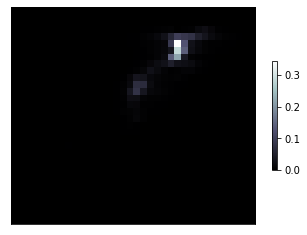

In [10]:
printimg(X[0][0])

In [11]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
            self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cuda()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cuda())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            # only record effective steps
            if step in self.effective_step:
                outputs.append(x)

        return outputs, (x, new_c)

In [27]:
# Test
# convlstm = ConvLSTM(input_channels=6, hidden_channels=[32,32,16,2], kernel_size=3, step=3,
#                         effective_step=[2]).cuda()
# loss_fn = torch.nn.MSELoss()

# input = Variable(torch.randn(1, 6, 64, 32)).cuda()
# target = Variable(torch.randn(1 ,2, 64, 32)).double().cuda()

# output = convlstm(input)
# output = output[0][0].double()
# res = torch.autograd.gradcheck(loss_fn, (output, target), eps=1e-6, raise_exception=True)
# print(res)


KeyboardInterrupt: 

In [15]:

convlstm = ConvLSTM(input_channels=6, hidden_channels=[128,64,32,32,1], kernel_size=3, step=4,
                        effective_step=[3]).cuda()
loss_function = nn.MSELoss()
#optimizer = torch.optim.SGD(convlstm.parameters(),lr=0.001)
#optimizer = torch.optim.RMSprop(convlstm.parameters(),lr=0.01)
optimizer = torch.optim.Adam(convlstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
convlstm.train()
for epoch in range(100):
    loader = DataLoader(train_ds, batch_size=16,shuffle = True)
    convlstm.train()
    for step,(batch_x,batch_y) in enumerate(loader):
        print(step)
        batch_x=batch_x.float()
        y_pred = convlstm(Variable(batch_x))[0][0].reshape(convlstm(Variable(batch_x))[0][0].shape[0],shape1,shape2)
        print(y_pred.shape)
        loss = torch.sqrt(loss_function(y_pred,batch_y.float()))
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(convlstm,'C:/Users/asus/Desktop/CITS5553/conlstm1')

0
torch.Size([16, 32, 36])
tensor(0.0518, device='cuda:0', grad_fn=<SqrtBackward0>)
1
torch.Size([16, 32, 36])
tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
2
torch.Size([16, 32, 36])
tensor(0.0467, device='cuda:0', grad_fn=<SqrtBackward0>)
3
torch.Size([16, 32, 36])
tensor(0.0387, device='cuda:0', grad_fn=<SqrtBackward0>)
4
torch.Size([16, 32, 36])
tensor(0.0406, device='cuda:0', grad_fn=<SqrtBackward0>)
5
torch.Size([16, 32, 36])
tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
6
torch.Size([16, 32, 36])
tensor(0.0429, device='cuda:0', grad_fn=<SqrtBackward0>)
7
torch.Size([16, 32, 36])
tensor(0.0446, device='cuda:0', grad_fn=<SqrtBackward0>)
8
torch.Size([16, 32, 36])
tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)
9
torch.Size([16, 32, 36])
tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
10
torch.Size([16, 32, 36])
tensor(0.0426, device='cuda:0', grad_fn=<SqrtBackward0>)
11
torch.Size([16, 32, 36])
tensor(0.0395, device='cuda:0', grad_fn=<SqrtBa

In [16]:
convlstm = torch.load('C:/Users/asus/Desktop/CITS5553/conlstm1')

In [17]:
testds = DataLoader(test_ds, batch_size=16,shuffle = True)
running_loss = 0.
convlstm.eval()
for step,(batch_tx,batch_ty) in enumerate(testds):
    batch_tx=batch_tx.float()
    yt_pred = convlstm(Variable(batch_tx))[0][0].reshape(convlstm(Variable(batch_tx))[0][0].shape[0],shape1,shape2)
    print(yt_pred.shape)
    for i in range(convlstm(Variable(batch_tx))[0][0].shape[0]):
        #printimg(yt_pred[i].reshape(shape1,shape2).detach())
        #print(yt_pred[i])
        #printimg(batch_ty[i].reshape(shape1,shape2).detach())
        print(torch.sqrt(loss_function(yt_pred[i], batch_ty[i].float())))
    loss = torch.sqrt(loss_function(yt_pred, batch_ty.float()))
    running_loss += (loss.item() - running_loss) / (step + 1)

print("Test loss: {};".format(running_loss))

torch.Size([16, 32, 36])
tensor(0.0359, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0447, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0484, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0579, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0396, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0281, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0246, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0232, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0226, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0188, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0290, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 32, 36])
tensor(0.0576, device='cuda:0', grad_f

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(6,32,kernel_size = 5),nn.MaxPool2d(2),nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(32,64,kernel_size = 5),nn.ReLU())
        self.fc1 = nn.Sequential(nn.Linear(7680,15360),nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(15360,shape1*shape2))

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)
        print(x.shape)
        x = x.view(batch_size,-1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [15]:
model = CNN().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

for epoch in range(100):
    loader = DataLoader(train_ds, batch_size=16,shuffle = True)
    model.train()
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x=batch_x.float()
        y_pred = model(batch_x).reshape(batch_x.shape[0],shape1,shape2)
        print(y_pred.shape)
        print(batch_y.shape)
        print(step,model(batch_x).shape)
        loss = torch.sqrt(loss_function(y_pred,batch_y.float()))
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(model,'C:/Users/asus/Desktop/CITS5553/cnn')


torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
0 torch.Size([16, 1152])
tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
1 torch.Size([16, 1152])
tensor(0.3578, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
2 torch.Size([16, 1152])
tensor(0.0353, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
3 torch.Size([16, 1152])
tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
4 torch.Size([16, 1152])
tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 3

In [16]:
CNN = torch.load('C:/Users/asus/Desktop/CITS5553/cnn')

In [21]:
#CNN = torch.load('C:/Users/asus/Desktop/CITS5553/cnn')
testds = DataLoader(test_ds, batch_size=16,shuffle = True)
running_loss = 0.
CNN.eval()
for step,(batch_tx,batch_ty) in enumerate(testds):
    batch_tx=batch_tx.float()
    yt_pred = CNN(batch_tx).reshape(CNN(batch_tx).shape[0],shape1,shape2)
    print(yt_pred.shape)
    for i in range(CNN(batch_tx).shape[0]):
        #printimg(yt_pred[i].reshape(shape1,shape2).detach())
        #print(yt_pred[i])
        #printimg(batch_ty[i].reshape(shape1,shape2).detach())
        print(torch.sqrt(loss_function(yt_pred[i], batch_ty[i].float())))
    loss = torch.sqrt(loss_function(yt_pred, batch_ty.float()))
    running_loss += (loss.item() - running_loss) / (step + 1)

print("Test loss: {};".format(running_loss))

torch.Size([16, 64, 10, 12])
torch.Size([16, 64, 10, 12])
torch.Size([16, 32, 36])
torch.Size([16, 64, 10, 12])
tensor(0.0326, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0251, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0471, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0295, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0230, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0549, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0566, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0560, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0445, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0451, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0349, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0309, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0307, device='cuda:0', g

In [12]:
input_size=shape1*shape2
sequence_length=6
num_layers=2
hidden_size=shape1*shape2*2

learning_rate = 0.001
num_epochs = 5

num_classes =shape1*shape2

In [13]:
class SimpleGRU(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,sequence_length=sequence_length):
        super(SimpleGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,dropout = 0.5)
        self.fc1 = nn.Linear(hidden_size*sequence_length, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        out,_ = self.gru(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        return out

In [14]:
GRUmodel = SimpleGRU().cuda()

In [16]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

for epoch in range(100):
    loader = DataLoader(train_ds, batch_size=16,shuffle = True)
    GRUmodel.train()
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x=batch_x.float()
        y_pred = GRUmodel(batch_x.reshape(batch_x.shape[0],6,shape1*shape2))
        print(step,y_pred.shape)
        loss = torch.sqrt(loss_function(y_pred,batch_y.reshape(batch_y.shape[0],shape1*shape2).float()))
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(GRUmodel,'C:/Users/asus/Desktop/CITS5553/gru')

0 torch.Size([16, 1152])
tensor(0.0438, device='cuda:0', grad_fn=<SqrtBackward0>)
1 torch.Size([16, 1152])
tensor(0.0930, device='cuda:0', grad_fn=<SqrtBackward0>)
2 torch.Size([16, 1152])
tensor(0.3517, device='cuda:0', grad_fn=<SqrtBackward0>)
3 torch.Size([16, 1152])
tensor(0.1147, device='cuda:0', grad_fn=<SqrtBackward0>)
4 torch.Size([16, 1152])
tensor(0.0592, device='cuda:0', grad_fn=<SqrtBackward0>)
5 torch.Size([16, 1152])
tensor(0.0556, device='cuda:0', grad_fn=<SqrtBackward0>)
6 torch.Size([16, 1152])
tensor(0.0925, device='cuda:0', grad_fn=<SqrtBackward0>)
7 torch.Size([16, 1152])
tensor(0.0864, device='cuda:0', grad_fn=<SqrtBackward0>)
8 torch.Size([16, 1152])
tensor(0.0525, device='cuda:0', grad_fn=<SqrtBackward0>)
9 torch.Size([16, 1152])
tensor(0.0931, device='cuda:0', grad_fn=<SqrtBackward0>)
10 torch.Size([16, 1152])
tensor(0.0577, device='cuda:0', grad_fn=<SqrtBackward0>)
11 torch.Size([16, 1152])
tensor(0.0667, device='cuda:0', grad_fn=<SqrtBackward0>)
12 torch.Size(

In [17]:
GRUmd = torch.load('C:/Users/asus/Desktop/CITS5553/gru')

In [19]:
loss_function = nn.MSELoss()
testds = DataLoader(test_ds, batch_size=16,shuffle = True)
running_loss = 0.
GRUmd.eval()
for step,(batch_tx,batch_ty) in enumerate(testds):
    batch_tx=batch_tx.float()
    print(batch_tx.shape)
    yt_pred = GRUmd(batch_tx.reshape(batch_tx.shape[0],6,shape1*shape2))
    print(yt_pred.shape)
    for i in range(GRUmd(batch_tx.reshape(batch_tx.shape[0],6,shape1*shape2)).shape[0]):
        #printimg(yt_pred[i].reshape(shape1,shape2).detach())
        #print(yt_pred[i])
        #printimg(batch_ty[i].reshape(shape1,shape2).detach())
        print(torch.sqrt(loss_function(yt_pred[i], batch_ty[i].reshape(shape1*shape2).float())))
    loss = torch.sqrt(loss_function(yt_pred, batch_ty.reshape(batch_ty.shape[0],shape1*shape2).float()))
    running_loss += (loss.item() - running_loss) / (step + 1)

print("Test loss: {};".format(running_loss))

torch.Size([16, 6, 32, 36])
torch.Size([16, 1152])
tensor(0.0210, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0609, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0474, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0751, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0539, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0240, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0467, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0234, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0194, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0519, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0189, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0298, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.0280, device='cuda:0', grad_fn=<SqrtBackward0>)
torch.Size([16, 6, 32, 36])
torch.Siz